<a href="https://colab.research.google.com/github/aslanides/aslanides.github.io/blob/master/colabs/2019-10-20-pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensionality Reduction via Principal Component Analysis

Principal component analysis (PCA) is a 'classical' machine learning technique for _dimensionality reduction_: the problem of finding 'good' low-dimensional approximations for high-dimensional objects. 

More formally, say we have a $N$ data points $\left\{x^{(n)}\right\}_{n=1}^N$ with each $x^{(n)}\in\mathbb{R}^D$, and with zero mean so that $\sum_{n=1}^N x^{(n)}=0$. In the case of PCA, we want to find a linear transformation that projects this data into a smaller subspace of dimensionality $K < D$.

Most discussions of PCA cast it as 'find the projection that maximizes the variance of the data within this subpsace'. I prefer the formulation that casts it as 'find the projection that minimizes the approximation/reconstruction error'. These two formulations are equivalent; the first connects better with the statistical notion of 'explained variance', but the second connects better to signal processing, information theory, and the rest of machine learning.

Let's flesh it out the second formulation, as this connects naturally to compression and autoencoders, which we will discuss in a follow-up post.



Consider a complete orthonormal basis set for $\mathbb{R}^D$ given by $\left\{b_k\right\}_{k=1}^D$ so that $b_j^T b_k=\delta_{jk}$.

Now, say we want to use $K$ of these basis vectors to approximate the $x$ with $\hat{x}$. Then because of orthonormality & completeness

$$
\begin{align}
x^{(n)} &= \sum_{k=1}^D b_k b_k^T x^{(n)} \\
        &= \underbrace{\sum_{k=1}^K b_k b_k^T x^{(n)}}_{\hat{x}^{(n)}} + \underbrace{\sum_{k=K+1}^D b_k b_k^T x^{(n)}}_{\epsilon^{(n)}}
\end{align}
$$

We want to choose the $b_k$ so as to minimize the Euclidean norm of the approximation error $\epsilon$ over the whole dataset, i.e.

$$
\begin{align}
\sum_{n=1}^N \left\| \epsilon^{(n)} \right\|_2^2 &= \sum_{n=1}^N \left\|\sum_{k=K+1}^D b_k b_k^T x^{(n)}\right\|_2^2 \\
  &= \sum_{n=1}^N \left(\sum_{j=K+1}^D b_j b_j^T x^{(n)}\right)^T \left(\sum_{k=K+1}^D b_k b_k^T x^{(n)}\right) \\
  &= \sum_{n=1}^N \sum_{j=K+1}^D \sum_{k=K+1}^D \left(b_j b_j^T x^{(n)}\right)^T b_k b_k^T x^{(n)} \\
  &= \sum_{n=1}^N \sum_{j=K+1}^D \sum_{k=K+1}^D {x^{(n)}}^T b_j b_j^T b_k b_k^T x^{(n)} \\
  &= \sum_{n=1}^N \sum_{j=K+1}^D \sum_{k=K+1}^D {x^{(n)}}^T b_j \delta_{jk} b_k^T x^{(n)} \\
  &= \sum_{n=1}^N \sum_{k=K+1}^D {x^{(n)}}^T b_k b_k^T x^{(n)} \\
  &= \sum_{n=1}^N \sum_{k=K+1}^D b_k^T x^{(n)} {x^{(n)}}^T b_k \\
  &= \sum_{k=K+1}^D b_k^T X^TX b_k,
\end{align}
$$

where each row of $X$ is an example $x^{(n)}$. Note that $X^TX\in\mathbb{R}^D$ is the covariance matrix, since $X$ has zero mean.



The objective becomes the quadratic program

$$
\begin{align}
\min_{b_k} \sum_{k=K+1}^D b^T_k X^TX b_k \\
\text{subject to } b_k^T b_k=1
\end{align}
$$

We can absorb this constraint into the objective using Lagrange multipliers:

$$
J = \sum_{k=K+1}^D \Big\{ b^T_k X^TX b_k + \lambda_k\left(1 - b_k^T b_k \right)\Big\}
$$

Setting derivatives w.r.t. $b_k$ equal to zero yields

$$
\begin{align}
0 &= \partial_{b_k} J \\
  &= X^TXb_k - \lambda_k b_k,
\end{align}
$$

which implies that each of the $b_k$ is an eigenvector of $X^TX$. Substituting back into the objective, we see

$$
J_{\mathrm{stationary}} = \sum_{k=K+1}^D \lambda_k,
$$

so the objective is minimized if we pick the 'residiual' vectors $\left\{b_k\right\}_{k=K+1}^D$ as the eigenvectors of $X^TX$ with smallest eigenvalues $\lambda_k$. Because of orthonormality, we see that therefore the 'projection' vectors $\left\{b_k\right\}_{k=1}^K$ are the eigenvectors of $X^TX$ with largest eigenvalues. This follows since each of the $\lambda_k$ are non-negative, because the covariance matrix is positive semi-definite.

In practice, we take advantage of the fact that the singular value decomposition (SVD) of a matrix $X$ yields the eigensystem of $X^TX$, sorted by absolute value of the eigenvalues.

Let's implement this in `numpy` and apply it to a couple of examples: first a synthetic one in two dimensions to get the intuition, then to images.

In [0]:
# @title Imports

import numpy as np
import pandas as pd
import plotnine as gg
from scipy import stats

import warnings
warnings.filterwarnings('ignore')  # Squash deprecation warnings etc.

gg.theme_set(gg.theme_bw());

In [0]:
# @title PCA via SVD

def pca(X: np.ndarray, K: int, zero_mean: bool = False):
  # X is 2-dimensional: each row an example, each column a feature.
  if zero_mean:
    X = X.copy()
    X -= X.mean(axis=0, keepdims=True)

  _, _, eigenvectors = np.linalg.svd(X)
  return eigenvectors[:K]

## Simple example on synthetic data

Say we have data in two dimensions, distributed according to a multivate Gaussian. Let's find the first principal component, and demonstrate that this direction is clearly the direction of 'maximal variance', and also the subspace which minimizes the approximation error.

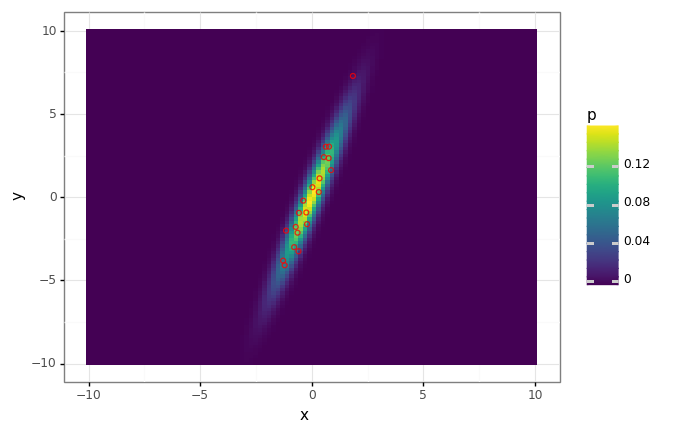

<ggplot: (-9223363266009775679)>

In [32]:
# Create a multivariate normal distribution.
distribution = stats.multivariate_normal(
    mean=[0., 0.],
    cov=[[1., 3.], 
         [3., 10.]],
)

# Evaluate its pdf on a grid.
xs = np.linspace(-10, 10, num=100)
ys = np.linspace(-10, 10, num=100)
xx, yy = np.meshgrid(xs, ys)
ps = distribution.pdf(np.array([yy, xx]).T)

# Draw a small dataset of samples.
X = distribution.rvs(size=20)

# Plot the density function along with the samples.
eval_df = pd.DataFrame({
    'x': xx.flatten(),
    'y': yy.flatten(),
    'p': ps.flatten(),
})

data_df = pd.DataFrame({
    'x': X[:, 0],
    'y': X[:, 1],
})

dist_plot = (
    gg.ggplot(eval_df)
    + gg.aes(x='x', y='y')
    + gg.geom_tile(gg.aes(fill='p'))
)

dist_plot + gg.geom_point(data=data_df, fill='none', color='red', alpha=0.8)

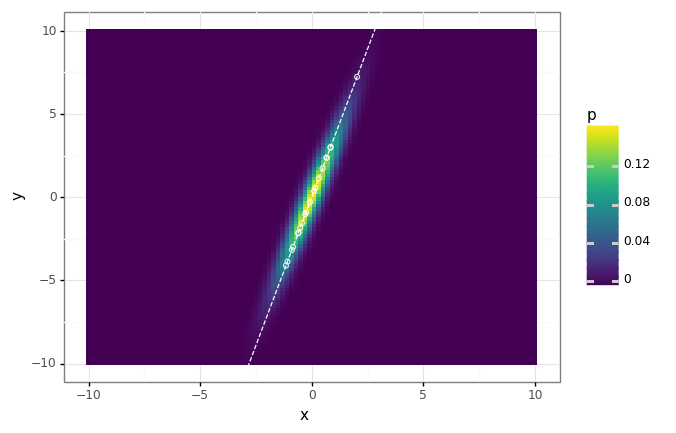

<ggplot: (-9223363266009772961)>

In [33]:
# Find the first principal component.
components = pca(X, K=1)

# Make the reconstruction \hat{x} for each data point.
X_hat = X @ components.T @ components

proj_df = pd.DataFrame({
    'x': X_hat[:, 0],
    'y': X_hat[:, 1],
})

# Project the data onto the first principal component. 
# Unsurprisingly this is the 'major axis' eigenvector of the covariance matrix.
(dist_plot
 + gg.geom_abline(intercept=0, slope=components[0, 1] / components[0, 0], linetype='dashed', color='white') 
 + gg.geom_point(data=proj_df, fill='none', color='white', alpha=0.8)
)

## MNIST example

In this example we'll do PCA on MNIST digits, and looks at how good our reconstructions get as we increase $K$, the number of principal components we keep. Unsurprisingly, the more we have, the better the approximation gets. Because we're limited to expressing our 'compression' of the images via linear projections, it turns out we need quite a few components to get reasonable reconstructions; we'll see in later post(s) that we can do a lot better with non-linear schemes (e.g. autoencoders)

In [0]:
# Shouldn't really need to do this, but there you have it.
! pip install --quiet tensorflow==2.0

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf  # Only needed for dataset pipelining with tfds.
import tensorflow_datasets as tfds

In [0]:
# We're going to work with one 'batch' of N samples.
N = 1000

# Download data & do basic preprocessing.
dataset = tfds.load('mnist', as_supervised=True, split=tfds.Split.ALL)
dataset = dataset.map(lambda image, _: tf.squeeze(tf.image.convert_image_dtype(image, tf.float32), axis=-1))
dataset = dataset.batch(N, drop_remainder=True)
iterator = iter(dataset)

# Get image shapes.
image_shape = dataset.output_shapes[1:].as_list()
flat_shape = np.prod(image_shape)

# Pull out some data & flatten it.
X_image = next(iterator)
X_image = X_image.numpy()
X = X_image.copy().reshape(-1, flat_shape)

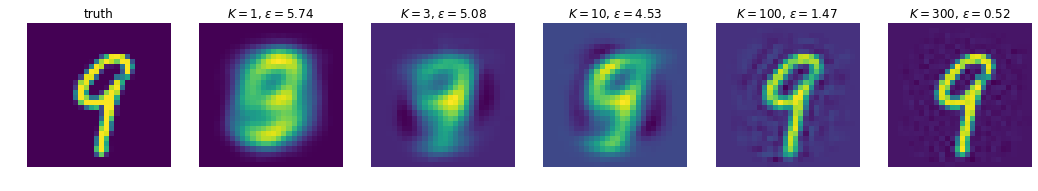

In [37]:
# Compute the first 300 principal components
components = pca(X, K=300)

# Now look at the contributions of these.
Ks = [1, 3, 10, 100, 300]
num_images = len(Ks) + 1

# Pick a random image to reconstruct.
idx = np.random.randint(N)
x_image = X_image[idx]
x = X[idx]

# Plot the ground truth.
fig, axes = plt.subplots(1, num_images, figsize=(3 * num_images, 3))
ax = axes[0]
ax.imshow(x_image)
ax.axis('off')
ax.set_title('truth')

for i, K in enumerate(Ks):
  # Compute reconstruction & error using the first K components.
  first_K_components = components[:K]
  x_hat = x @ first_K_components.T @ first_K_components
  x_hat_image = np.reshape(x_hat, image_shape)
  epsilon = np.linalg.norm(x_hat - x)

  # Plot this reconstruction.
  ax = axes[i+1]
  ax.imshow(x_hat_image)
  ax.axis('off')
  ax.set_title(f'$K={K}$, $\epsilon={epsilon:.2f}$')
fig.show()